<a href="https://colab.research.google.com/github/Cuzime/ASTRON-128/blob/main/ZTF_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
! pip install photutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch, MinMaxInterval, SqrtStretch, ImageNormalize, SinhStretch
from sklearn.preprocessing import PowerTransformer
import random
import math
import keras
import os
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from sklearn.preprocessing import StandardScaler
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow_probability as tfp
import time
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow Version: 2.14.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [37]:
# set size of stamps
size = 256
stamps_per_img = 300
step = int(size/2)

def get_image(index, quad):
    file_name = file_list[index]
    file_path = folder_path + file_name
    hdu_1 = fits.open(file_path)
    image_data = hdu_1[quad].data
    hdu_1.close()

    return image_data

def visual_transform_image(image):
    # VISUALIZE THE DATA

    # Scale the image based on its percentiles
    interval = PercentileInterval(99.5)
    vmin, vmax = interval.get_limits(image)
    norm = plt.Normalize(vmin, vmax)

    # Apply an asinh stretch to enhance faint features
    stretch = AsinhStretch()
    scaled_data = stretch(norm(image))

    return scaled_data

def get_stamps(image):
    # get image dimensions
    naxis1,naxis2 = np.shape(image)
    x_centers = np.arange(step, naxis1-step, step)
    y_centers = np.arange(step, naxis2-step, step)
    stamps = []
    for x_center in x_centers:
        for y_center in y_centers:
            stamp = image[y_center-step:y_center+step, x_center-step:x_center+step]
            stamps.append(stamp)

    stamps = np.array(stamps)

    return stamps.reshape(stamps.shape[0], stamps.shape[1], stamps.shape[2], 1)

# ZTF raw stamps generator

In [7]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-001.zip > /dev/null

In [8]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-002.zip > /dev/null

In [9]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-003.zip > /dev/null

In [10]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-004.zip > /dev/null

In [11]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps2-20231117T014814Z-001.zip > /dev/null

In [13]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps2-20231117T014814Z-002.zip > /dev/null

In [12]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps2-20231117T014814Z-003.zip > /dev/null

In [14]:
# unzip masks
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-20231110T010359Z-001.zip > /dev/null

In [15]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-20231110T010359Z-002.zip > /dev/null

In [16]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask2-20231117T014817Z-001.zip > /dev/null

In [17]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask2-20231117T014817Z-002.zip > /dev/null

In [42]:
folder_path = '/content/ZTFrawstamps'
file_list = os.listdir(folder_path)

folder_path2 = '/content/ZTFrawstamps2'
file_list2 = os.listdir(folder_path2)

folder_path_masks = '/content/ZTFrawstampsmask'
file_list_masks = os.listdir(folder_path_masks)

folder_path_masks2 = '/content/ZTFrawstampsmask2'
file_list_masks2 = os.listdir(folder_path_masks2)

full_path_list = []
for file_name in file_list:
  file_path = folder_path + '/' + file_name
  full_path_list.append(file_path)

for file_name in file_list2:
  file_path = folder_path2 + '/' + file_name
  full_path_list.append(file_path)

print(len(full_path_list))

mask_path_list = []
for file_name in file_list_masks:
  file_path = folder_path_masks + '/' + file_name
  mask_path_list.append(file_path)

for file_name in file_list_masks2:
  file_path = folder_path_masks2 + '/' + file_name
  mask_path_list.append(file_path)

print(len(mask_path_list))

train_path_list = full_path_list[0:100000]
test_path_list = full_path_list[100000:]

print('number of training data:', len(train_path_list))
print('number of testing data:', len(test_path_list))

106737
106737
number of training data: 100000
number of testing data: 6737


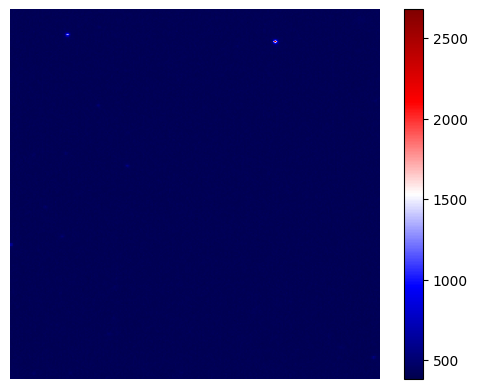

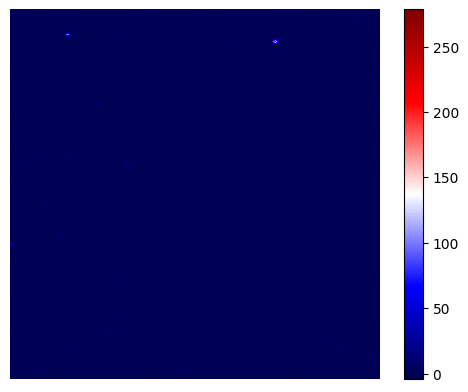

In [61]:
from astropy.visualization import SqrtStretch, AsinhStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

def rescale_astronomical_image(image, bkg_sigma=3.0,
                               window=(50,50),
                               filter_size=(3,3),
                               maxiters=10,
                               npixels=10,
                               radius=3):
    """Rescale an image based on the noise
       See https://photutils.readthedocs.io/en/stable/background.html#sigma-clipping-sources
    """

    # First, estimate the background image
    sigma_clip = SigmaClip(sigma=bkg_sigma)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, window, filter_size=filter_size,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

    # subtract off the background
    new_im = image - bkg.background

    # mask sources and get the stats
    sigma_clip = SigmaClip(sigma=bkg_sigma, maxiters=maxiters)
    threshold = detect_threshold(new_im, nsigma=bkg_sigma-2, sigma_clip=sigma_clip)
    segment_img = detect_sources(new_im, threshold, npixels=npixels)
    footprint = circular_footprint(radius=radius)
    mask = segment_img.make_source_mask(footprint=footprint)
    _, median, std = sigma_clipped_stats(new_im, sigma=bkg_sigma, mask=mask)

    # Rescale
    new_im -= median
    new_im /= std

    return new_im, mask, median, std

# random image
idx = np.random.randint(0, len(test_path_list))
file_path = test_path_list[idx]
mask_path = '/content/ZTFrawstampsmask2/' + file_path[22:-4] + '_mask.npy'

#index = 12
#quad = 1



for i in range(1):

    # random image
    idx = np.random.randint(0, len(test_path_list))
    file_path = test_path_list[idx]
    mask_path = '/content/ZTFrawstampsmask2/' + file_path[22:-4] + '_mask.npy'

    image = np.load(file_path)
    mask = np.load(mask_path)

    visual_stamp = image
    #plt.figure(figsize = (7,7))
    #plt.title('original stamp')
    #plt.imshow(visual_stamp.reshape(stamps.shape[1], stamps.shape[2]), cmap = 'gray')
    #plt.colorbar()
    plt.figure()
    plt.imshow(visual_stamp.reshape(image.shape[0], image.shape[1]), cmap = 'seismic')
    plt.colorbar()
    plt.axis('off')

    # rescale and mask
    im, mask, median, std  = rescale_astronomical_image(image.reshape(image.shape[0], image.shape[1]))
    visual_im = im

    #plt.figure(figsize = (7,7))
    #plt.title('scaled stamp and masked')
    #plt.imshow(visual_im_masked.reshape(stamps.shape[1], stamps.shape[2]), cmap = 'gray')
    #plt.colorbar()

    plt.figure()
    plt.imshow(visual_im.reshape(image.shape[0], image.shape[1]), cmap = 'seismic')
    plt.axis('off')
    plt.colorbar()



10.21855902671814
(15, 256, 256, 1)
(15, 256, 256, 1)


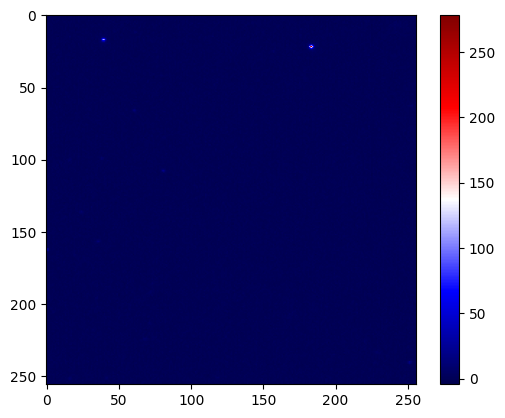

In [94]:
# raw stamps generator


def generate_train_stamps_mask_raw(batch_size):
  while True:
    counter = 0
    stamp_list = []
    mask_list = []
    for file_path in train_path_list:
      if (counter == batch_size):
        counter = 0
        yield (np.array(stamp_list), np.array(mask_list))
        #yield np.array(stamp_list)
        stamp_list = []
        mask_list = []

      image_data = np.load(file_path)
      mask_data = np.load('/content/ZTFrawstampsmask/' + file_path[22:-4] + '_mask.npy')
      mask_data = mask_data.reshape(256,256,1)

      im, mask, median, std  = rescale_astronomical_image(image.reshape(image.shape[0], image.shape[1]))

      #interval = MinMaxInterval()
      #vmin, vmax = interval.get_limits(image_data)
      #image_data_scaled = np.log10(image_data-vmin+1)
      image_data_scaled = im.reshape(256,256,1)

      mask_list.append(mask_data)
      stamp_list.append(image_data_scaled)
      counter += 1

def generate_test_stamps_mask_raw(batch_size):
  while True:
    counter = 0
    stamp_list = []
    mask_list = []
    for file_path in test_path_list:
      if (counter == batch_size):
        counter = 0
        yield (np.array(stamp_list), np.array(mask_list))
        #yield np.array(stamp_list)
        stamp_list = []
        mask_list = []

      image_data = np.load(file_path)
      mask_data = np.load('/content/ZTFrawstampsmask2/' + file_path[22:-4] + '_mask.npy')
      mask_data = mask_data.reshape(256,256,1)

      im, mask, median, std  = rescale_astronomical_image(image.reshape(image.shape[0], image.shape[1]))

      #interval = MinMaxInterval()
      #vmin, vmax = interval.get_limits(image_data)
      #image_data_scaled = np.log10(image_data-vmin+1)
      image_data_scaled = im.reshape(256,256,1)

      mask_list.append(mask_data)
      stamp_list.append(image_data_scaled)
      counter += 1


gen = generate_train_stamps_mask_raw(15)

start = time.time()
for i in range(10):
  stamps, masks = next(gen)
  #stamps = next(gen)
end = time.time()
print(end-start)
print(np.shape(stamps))
print(np.shape(masks))

idx = 6
#interval = MinMaxInterval()
#vmin, vmax = interval.get_limits(stamps[idx])
#stamp = np.log10(stamps[idx]-vmin+1)



plt.imshow(stamps[idx].reshape(256,256),cmap = 'seismic')
plt.colorbar()


In [ ]:
mask_data = np.load('/content/ZTFrawstampsmask2/' + file_path[22:-4] + '_mask.npy')

# PixelCNN Autoencoder

In [95]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [96]:
shape = (size, size)
input_shape = (size, size, 1)

# PixelCNN Autoencoder
class PCNNae(keras.Model):

    def gae_compile(self,
                    encoder,
                    mean_model,
                    var_model,
                    encoder_optimizer,
                    mean_optimizer,
                    var_optimizer,
                    epsilon=1,
                    beta = 1,
                    **kwargs):
        super().compile()
        self.mean_optimizer = mean_optimizer
        self.var_optimizer = var_optimizer
        self.encoder_optimizer = encoder_optimizer
        self.mle_loss_tracker = keras.metrics.Mean(name="mle_loss")
        #self.kl_loss_tracker = keras.metrics.Mean(name ="kl_loss")
        self.var_loss_tracker = keras.metrics.Mean(name="var_loss")
        self.mse_tracker = keras.metrics.Mean(name = "mse")
        self.beta = beta
        self.epsilon = epsilon
        self.mean_model = mean_model
        self.var_model = var_model
        self.encoder = encoder

    def train_step(self, data):
        stamps, masks = data
        masks = tf.cast(masks, tf.float32)
        #stamps = data

        """"FULLY CONV MODEL WITHOUT TUNING"""
        with tf.GradientTape(persistent = True) as tape:
            # forward pass mean
            codes = self.encoder(stamps, training = True)

            mean_img = self.mean_model(codes, training = True)
            """Calculate MSE loss"""
            # added element wise multiplication with masks
            mse = K.mean(tf.math.multiply(K.square(mean_img - stamps), masks))
            #mse = K.mean(K.square(mean_img - stamps))

        # apply gradients to mean model
        mean_grads = tape.gradient(mse, self.mean_model.trainable_weights)
        encoder_grads = tape.gradient(mse, self.encoder.trainable_weights)
        self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
        self.mean_optimizer.apply_gradients(zip(mean_grads, self.mean_model.trainable_weights))

        with tf.GradientTape(persistent = True) as tape:
            # forward pass variance
            codes = self.encoder(stamps, training = True)

            var_img = self.var_model(codes, training = True)
            mean_img = self.mean_model(codes, training = False)

            """Calulate MLE loss"""
            mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - stamps) / (var_img+self.epsilon)
            mle_loss = K.mean(mle_loss)

            "Variance Loss"
            var_loss = mle_loss

        # apply gradients to var model
        var_grads = tape.gradient(var_loss, self.var_model.trainable_weights)
        self.var_optimizer.apply_gradients(zip(var_grads, self.var_model.trainable_weights))
        # encoder_grads = tape.gradient(var_loss, self.encoder.trainable_weights)
        # self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))

        # update state of trackers
        self.mle_loss_tracker.update_state(mle_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        self.var_loss_tracker.update_state(var_loss)
        self.mse_tracker.update_state(mse)

        return {
            "mse": self.mse_tracker.result(),
            "var_loss": self.var_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
            "mle_loss": self.mle_loss_tracker.result()
        }

    def test_step(self, data):

        stamps, masks = data
        masks = tf.cast(masks, tf.float32)
        #stamps = data

        # forward pass
        codes = self.encoder(stamps, training = False)
        """"masking process"""
        #codes_shape = K.int_shape(codes)[1:]
        #comp_param = random.randint(1,64)
        #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
        #codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)
        #var_img = tf.abs(var_img)
        """Calculate MSE loss"""
        # added element wise multiplication with masks
        mse = K.mean(tf.math.multiply(K.square(mean_img - stamps), masks))
        #mse = K.mean(K.square(mean_img - stamps))

        """"Calculate MLE loss"""
        mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - stamps) / (var_img+self.epsilon)
        mle_loss = K.mean(mle_loss)

        "Variance Loss"
        var_loss = mle_loss

        self.mse_tracker.reset_states()
        self.mle_loss_tracker.reset_states()
        self.var_loss_tracker.reset_states()
        #self.kl_loss_tracker.reset_states()
        #self.kl_loss_tracker.update_state(kl_loss)
        self.mse_tracker.update_state(mse)
        self.mle_loss_tracker.update_state(mle_loss)
        self.var_loss_tracker.update_state(var_loss)

        return {
            "mse": self.mse_tracker.result(),
            "var_loss": self.var_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
            "mle_loss": self.mle_loss_tracker.result()
        }

    def custom_predict(self, data, comp_param):
        x = data
        # forward pass
        codes = self.encoder(x, training = False)
        """"masking process"""
        codes_shape = K.int_shape(codes)[1:]
        comp_param = comp_param
        #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
        #codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)

        return mean_img, var_img

In [99]:
# set hyperparameters
epochs = 300
batch_size = 64
steps_per_epoch = 500
enc_filters = [64,64,8]
dec_filters = [64,64,128]
learning_rate = 0.001
noise_std = 0.1
epsilon = noise_std**2
#percentile_interval = 99.5
#a = 0.1
beta = 0

# PixelCNN autoencoder architecture

with tf.device(device_name = '/device:GPU:0'):

    input = keras.Input(shape = input_shape)
    enc_layer = input

    # encoder
    enc_layer = PixelConvLayer(mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same")(enc_layer)
    enc_layer = keras.layers.BatchNormalization()(enc_layer)

    for filters in enc_filters:
      enc_layer = keras.layers.Conv2D(filters, (3,3), activation = 'relu', padding = 'same')(enc_layer)
      enc_layer = keras.layers.BatchNormalization()(enc_layer)
      enc_layer = keras.layers.MaxPooling2D((2,2), padding = 'same')(enc_layer)

    #shape_before_flatten = K.int_shape(enc_layer)[1:]

    mean_layer = enc_layer

    for filters in dec_filters:
      mean_layer = keras.layers.Conv2DTranspose(filters, (3,3), activation = 'relu', padding = 'same')(mean_layer)
      mean_layer = keras.layers.BatchNormalization()(mean_layer)
      mean_layer = keras.layers.UpSampling2D((2,2))(mean_layer)

    mean_layer = ResidualBlock(filters=128)(mean_layer)
    mean_layer = ResidualBlock(filters=128)(mean_layer)

    mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(mean_layer)
    mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(mean_layer)
    mean_predict = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="linear", padding="same")(mean_layer)

    var_layer = enc_layer

    for filters in dec_filters:
      var_layer = keras.layers.Conv2DTranspose(filters, (3,3), activation = 'relu', padding = 'same')(var_layer)
      var_layer = keras.layers.BatchNormalization()(var_layer)
      var_layer = keras.layers.UpSampling2D((2,2))(var_layer)


    var_layer = ResidualBlock(filters=128)(var_layer)
    var_layer = ResidualBlock(filters=128)(var_layer)

    var_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="valid")(var_layer)
    var_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="valid")(var_layer)
    var_predict = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="relu", padding="valid")(var_layer)

    mean_model = keras.Model(enc_layer, mean_predict, name = 'mean_model')
    var_model = keras.Model(enc_layer, var_predict, name = 'var_model')

    encoder = keras.Model(input, enc_layer, name = 'encoder')

    autoencoder_C = PCNNae(input, [mean_predict, var_predict])
    mean_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    var_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    autoencoder_C.gae_compile(mean_model = mean_model, var_model = var_model, encoder = encoder,
                                mean_optimizer=mean_optimizer, var_optimizer = var_optimizer,
                                encoder_optimizer = encoder_optimizer,
                                epsilon = epsilon,
                                beta = beta
                                )

    encoder.summary()
    mean_model.summary()
    var_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 pixel_conv_layer_81 (Pixel  (None, 256, 256, 128)     6400      
 ConvLayer)                                                      
                                                                 
 batch_normalization_90 (Ba  (None, 256, 256, 128)     512       
 tchNormalization)                                               
                                                                 
 conv2d_199 (Conv2D)         (None, 256, 256, 64)      73792     
                                                                 
 batch_normalization_91 (Ba  (None, 256, 256, 64)      256       
 tchNormalization)                                               
                                                           

In [100]:
# WANDB INIT

# start run, tracking hyperparameters
run = wandb.init(mode = 'online',
    #set project
    project = "PixelCNN_mask",

    config = {
        "epochs": epochs,
        "steps_per_epoch": steps_per_epoch,
        "batch_size": batch_size,
        "enc_filters": enc_filters,
        #"encoder_dense": encoding_dense,
        #"decoder_dense" : decoding_dense,
        "dec_filters": dec_filters,
        "input_shape": input_shape,
        "shape": shape,
        "noise_std": noise_std,
        "learning_rate": learning_rate,
        "epsilon": epsilon,
        "beta": beta,
        #"percentile_interval": percentile_interval,
        #"a": a,
    }
)


# FIT

lr = 0.0000001
lr = 0.0001

def scheduler(epoch, lr):
  if epoch < 30:
    return 0.001
  elif epoch < 60:
    return 0.001
  elif epoch < 100:
    return 0.001
  else:
    return 0.001

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

with tf.device(device_name = '/device:GPU:0'):
    autoencoder_C.fit(x = generate_train_stamps_mask_raw(20),
                    epochs = epochs,
                      steps_per_epoch = steps_per_epoch,
                      batch_size = batch_size,
                      validation_data=generate_test_stamps_mask_raw(20),
                      validation_steps = 100,
                      shuffle = True,
                    callbacks = [lr_scheduler, WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("/models/gae_model/", save_weights_only = True, monitor = 'val_loss')])

Epoch 1/300
500/500 [==============================] - ETA: 0s - mse: 0.0875 - var_loss: 0.7049 - mle_loss: 0.7049

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 838s 2s/step - mse: 0.0875 - var_loss: 0.7049 - mle_loss: 0.7049 - val_mle_loss: -0.3096 - val_var_loss: -0.3096 - val_mse: 0.0389 - lr: 0.0010
Epoch 2/300
500/500 [==============================] - ETA: 0s - mse: 0.0101 - var_loss: -1.7471 - mle_loss: -1.7471

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 904s 2s/step - mse: 0.0101 - var_loss: -1.7471 - mle_loss: -1.7471 - val_mle_loss: -3.0365 - val_var_loss: -3.0365 - val_mse: 0.0025 - lr: 0.0010
Epoch 3/300
500/500 [==============================] - ETA: 0s - mse: 0.0028 - var_loss: -3.0037 - mle_loss: -3.0037

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 889s 2s/step - mse: 0.0028 - var_loss: -3.0037 - mle_loss: -3.0037 - val_mle_loss: -1.7677 - val_var_loss: -1.7677 - val_mse: 0.0058 - lr: 0.0010
Epoch 4/300
500/500 [==============================] - ETA: 0s - mse: 0.0024 - var_loss: -3.5952 - mle_loss: -3.5952

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 827s 2s/step - mse: 0.0024 - var_loss: -3.5952 - mle_loss: -3.5952 - val_mle_loss: -4.3613 - val_var_loss: -4.3613 - val_mse: 3.2927e-04 - lr: 0.0010
Epoch 5/300
500/500 [==============================] - ETA: 0s - mse: 0.0016 - var_loss: -3.4435 - mle_loss: -3.4435

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 836s 2s/step - mse: 0.0016 - var_loss: -3.4435 - mle_loss: -3.4435 - val_mle_loss: -4.5412 - val_var_loss: -4.5412 - val_mse: 7.5279e-05 - lr: 0.0010
Epoch 6/300
500/500 [==============================] - ETA: 0s - mse: 0.0013 - var_loss: -3.7126 - mle_loss: -3.7126

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 843s 2s/step - mse: 0.0013 - var_loss: -3.7126 - mle_loss: -3.7126 - val_mle_loss: -4.4305 - val_var_loss: -4.4305 - val_mse: 2.3959e-04 - lr: 0.0010
Epoch 7/300
 84/500 [====>.........................] - ETA: 3:46 - mse: 0.0047 - var_loss: -0.6865 - mle_loss: -0.6865

UnknownError: ignored

In [101]:
wandb.finish()

batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/mle_loss,██▇▇▇▇▇▅▅▅▄▄▄▂▃▃▃▃▃▃▂▃▃▂▂▂▁▂▂▂▃▂▁▂▂▂▂▂▂▅
batch/mse,█▇▆▅▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/var_loss,██▇▇▇▇▇▅▅▅▄▄▄▂▃▃▃▃▃▃▂▃▃▂▂▂▁▂▂▂▃▂▁▂▂▂▂▂▂▅
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁
epoch/lr,▁▁▁▁▁▁
epoch/mle_loss,█▄▂▁▁▁
epoch/mse,█▂▁▁▁▁
epoch/val_mle_loss,█▃▆▁▁▁


/content/ZTFrawstamps2/ztf_20210505341817_000682_zr_c06_o.npy
/content/ZTFrawstampsmask2//ztf_20210505341817_000682_zr_c06_o_mask.npy
1/1 [==============================] - 0s 22ms/step


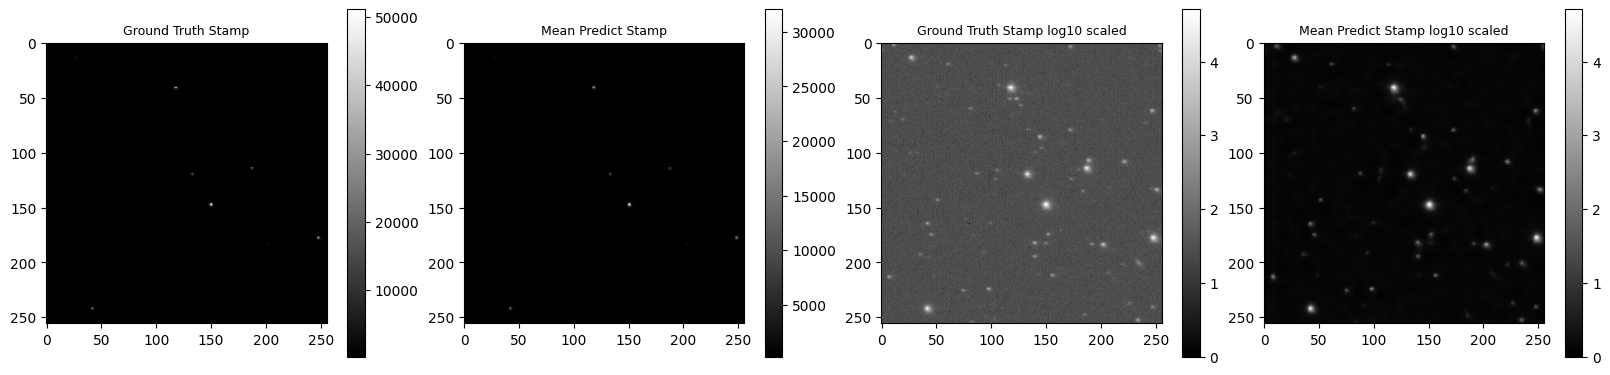

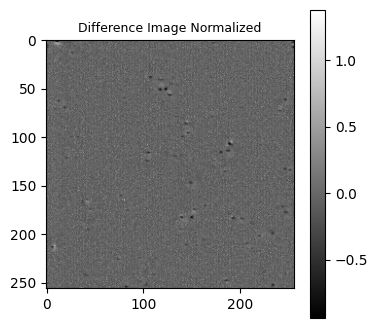

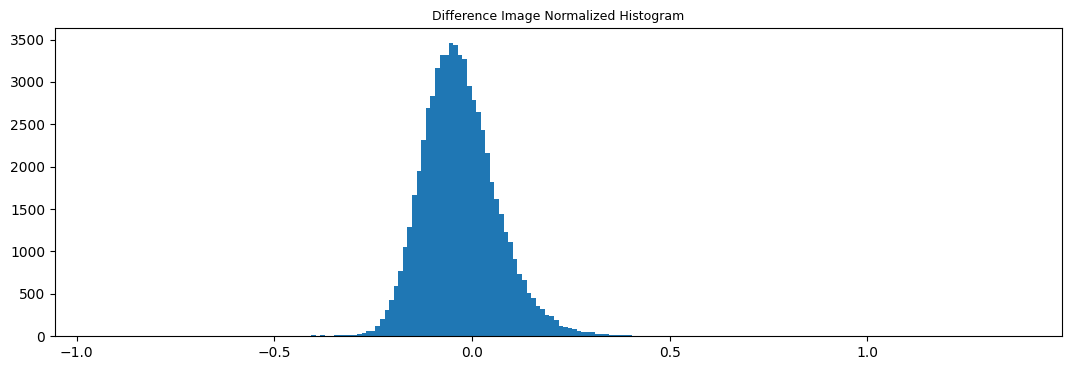

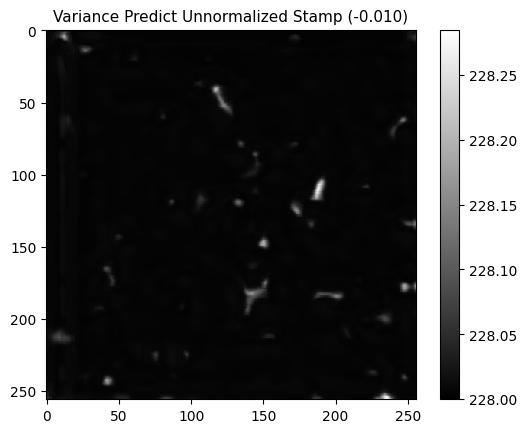

In [32]:
# test and visualize reconstruction

# random image
idx = np.random.randint(0, len(test_path_list))
file_path = test_path_list[idx]
mask_path = '/content/ZTFrawstampsmask2/' + file_path[22:-4] + '_mask.npy'

print(file_path)
print(mask_path)

image_data = np.load(file_path)
mask_data = np.load(mask_path)

original_stamp = image_data

im, mask, median, std  = rescale_astronomical_image(image.reshape(image.shape[0], image.shape[1]))

#interval = MinMaxInterval()
#vmin, vmax = interval.get_limits(image_data)
#image_data_scaled = np.log10(image_data-vmin+1)

image_data_scaled = im.reshape(256,256,1)

with tf.device(device_name = '/device:GPU:0'):
    mean_pred_img, var_pred_img = np.array(autoencoder_C.predict(image_data_scaled.reshape(1, size, size, 1)))
    mean_pred_img = mean_pred_img.reshape(shape)
    var_pred_img = var_pred_img.reshape(shape)


# mean (reconstructed) plots
fig, axs = plt.subplots(1, 4, figsize=(16, 10), gridspec_kw={'wspace': 0.0, 'hspace': 0.0},
                        constrained_layout=True)


im0 = axs[0].imshow(original_stamp.reshape(size,size), cmap='gray')
axs[0].set_title('Ground Truth Stamp', fontsize = 9)
fig.colorbar(im0, ax=axs[0], shrink=0.35)

mean_pred_img_un = mean_pred_img*std + median

im4 = axs[1].imshow(mean_pred_img_un, cmap='gray')
axs[1].set_title('Mean Predict Stamp' , fontsize=9)
fig.colorbar(im4, ax=axs[1], shrink=0.35)

original_stamp_masked = visual_transform_image(original_stamp).reshape(256,256,1)

im1 = axs[2].imshow(image_data_scaled.reshape(size,size), cmap='gray')
axs[2].set_title('Ground Truth Stamp log10 scaled', fontsize = 9)
fig.colorbar(im1, ax=axs[2], shrink=0.35)

mean_pred_masked = visual_transform_image(mean_pred_img.reshape(256,256,1)).reshape(256,256,1)

im2 = axs[3].imshow(mean_pred_img.reshape(256,256), cmap='gray')
axs[3].set_title('Mean Predict Stamp log10 scaled', fontsize = 9)
fig.colorbar(im1, ax=axs[3], shrink=0.35)

#reverted_mean_pred_img = ((10**mean_pred_img)-1+vmin)

diff_image = (np.array(mean_pred_img.reshape(size,size)) - np.array(image_data_scaled.reshape(size,size)))

fig = plt.figure(figsize=(4,4))
plt.imshow(diff_image.reshape(size,size), cmap = 'gray')
plt.title('Difference Image Normalized', fontsize=9)
plt.colorbar()

fig = plt.figure(figsize=(13,4))
diff_image_flat = diff_image.flatten()
diff_image_flat = diff_image_flat
plt.hist(diff_image_flat, bins = 200)
plt.title('Difference Image Normalized Histogram', fontsize=9)


# variance plots

reverted_var_pred_img = ((10**var_pred_img)-1+vmin)

plt.figure()
plt.imshow(reverted_var_pred_img.reshape(size,size), cmap = 'gray')
plt.title('Variance Predict Unnormalized Stamp (-{:.3f})'.format(epsilon), fontsize=11)
plt.colorbar()

In [26]:
# save weights
autoencoder_C.save_weights('/content/drive/MyDrive/model_weights/256_weights.h5')

In [23]:
# reload weights
autoencoder_C.load_weights('/content/drive/MyDrive/model_weights/256_weights.h5')